In [1]:
import random
from scipy.optimize import curve_fit
from scipy import stats
import math
import re
import plotly.graph_objects as go
import numpy as np
from scipy.stats import fisher_exact
from scipy import stats
from sklearn.linear_model import LinearRegression
import os

In [ ]:
"""
Алгоритм программы
1) Считываются файлы тренда и всех атрибутов. По ним схранются значения по координатам, размерность сетки и сами координаты
2) Проверяется правильно ли сделана разметка сеток и выставлены координаты всех файлов. Если где-то не сходятся координтаы, то необьходимо отправить пользователя переделать карты
3) Т.к. карта содержит очень большое количество точек, то будем брать значения с некоторой периодичностью (шагом)

"""

In [2]:
def open_coord(file):
    """
    Чтения файла Literal_trend
    """
    with open(file, 'r') as f:
        coord = []
        for line in f:
            if line.startswith('# Grid_space'):
                Grid_space = line[13:-1].split(',')
            if line.startswith('# Grid_size'):
                Grid_size = line[12:-1].split(' x ')
            if not line.startswith('#'):  # Пропуск строк, начинающихся с #
                x, y, z, i, j = line.split()  # Разбиение строки по столбцам
                x = float(x)
                y = float(y)
                z = float(z) 
                i = int (i)
                j = int(j)
                coord.append([x, y, z, i, j])  # Добавление данных в словарь

    return coord, Grid_space, Grid_size

In [34]:
Lateral_trend, Lateral_trend_Grid_space, Lateral_trend_Grid_size = open_coord('C:/HV/Seismic/datas/Lateral_trend_No_smooth_Heff.txt')
print(Lateral_trend[0:10])
print(len(Lateral_trend))
print(Lateral_trend_Grid_space)
print(Lateral_trend_Grid_size)

[[445946.632991, 7004198.214381, 72.554604, 2, 2], [445996.632991, 7004198.214381, 74.0868, 3, 2], [446046.632991, 7004198.214381, 74.0868, 4, 2], [446096.632991, 7004198.214381, 75.619003, 5, 2], [446146.632991, 7004198.214381, 74.0868, 6, 2], [446196.632991, 7004198.214381, 71.0224, 7, 2], [446246.632991, 7004198.214381, 72.554604, 8, 2], [446296.632991, 7004198.214381, 72.554604, 9, 2], [446346.632991, 7004198.214381, 74.0868, 10, 2], [446396.632991, 7004198.214381, 72.554604, 11, 2]]
80080
[' 445896.632991', '460246.632991', '7004148.214381', '7018198.214381']
[' 288', '282']


In [4]:
def atribusts(folder_path):
    """
    Проходимся по всем атрибутам в папке и собираем словарь в котором хранятся все данные атрибутов.
    Словарь{название файла : {data : [], Grid_space : [], Grid_size :[]}, ...}
    """
    Surf = {}
    files = os.listdir(folder_path)
    
    # Проходим по каждому файлу и создаем словари
    for file in files:
        if file.endswith('.txt'):
            var_name = file[:-4]  # Убираем '.txt'
        
            with open(os.path.join(folder_path, file), 'r') as f:
                coord = []
                for line in f:
                    if line.startswith('# Grid_space'):
                        Grid_space = line[13:-1].split(',')
                    if line.startswith('# Grid_size'):
                        Grid_size = line[12:-1].split(' x ')
                    if not line.startswith('#'):  # Пропуск строк, начинающихся с #
                        x, y, z, i, j = line.split()  # Разбиение строки по столбцам
                        x = float(x)
                        y = float(y)
                        z = float(z) 
                        i = int (i)
                        j = int(j)
                        coord.append([x, y, z, i, j])  # Добавление данных в словарь

            #   Создаем словарь для каждого файла с тремя ключами
            Surf[var_name] = {
                'data': coord,
                'Grid_space': Grid_space,
                'Grid_size': Grid_size
            }
    return Surf


In [35]:
Surface_attributes = atribusts('C:/HV/Seismic/datas/atributs')
print(Surface_attributes.keys())

dict_keys(['1_05_2_Top_Sweet_RMSh', '2_01_7_Fm_Amp_MaxM', '2_02_7_Fm_RMS_MaxM', '2_11_7_Fm_Amp_Contr_MaxM', 'AmplitudeContrast_HalfEnergy_TWT'])


In [36]:
print(Surface_attributes['1_05_2_Top_Sweet_RMSh']['data'][0:10])
print(Surface_attributes['1_05_2_Top_Sweet_RMSh']['Grid_space'])
print(Surface_attributes['1_05_2_Top_Sweet_RMSh']['Grid_size'])

[[445946.632991, 7004198.214381, 50.654621, 2, 2], [445996.632991, 7004198.214381, 85.337822, 3, 2], [446046.632991, 7004198.214381, 31.588446, 4, 2], [446096.632991, 7004198.214381, 165.998688, 5, 2], [446146.632991, 7004198.214381, 87.795975, 6, 2], [446196.632991, 7004198.214381, 193.958115, 7, 2], [446246.632991, 7004198.214381, 46.851452, 8, 2], [446296.632991, 7004198.214381, 93.091415, 9, 2], [446346.632991, 7004198.214381, 222.665771, 10, 2], [446396.632991, 7004198.214381, 186.160751, 11, 2]]
[' 445896.632991', '460246.632991', '7004148.214381', '7018198.214381']
[' 288', '282']


In [37]:
def proverka_kart(karta_space, karta_size, atribut_space, atribut_size):
    if karta_space == atribut_space:
        if karta_size == atribut_size:
            print('координаты карты и размерности сетки совпадают')
        else:
            print('размерности сетки не совпадают, переделайте сетку')
    else:
        print('координаты карты не совпадают, переделайте карту')
        
#proverka_kart(Literal_trend_Grid_space, Literal_trend_Grid_size, Surface_attribute_Grid_space, Surface_attribute_Grid_size)

In [38]:
for key in Surface_attributes:
    print(f'Для Lateral_trend и для {key}')
    proverka_kart(Lateral_trend_Grid_space, Lateral_trend_Grid_size, Surface_attributes[key]['Grid_space'], Surface_attributes[key]['Grid_size'])

Для Literal_trend и для 1_05_2_Top_Sweet_RMSh
координаты карты и размерности сетки совпадают
Для Literal_trend и для 2_01_7_Fm_Amp_MaxM
координаты карты и размерности сетки совпадают
Для Literal_trend и для 2_02_7_Fm_RMS_MaxM
координаты карты и размерности сетки совпадают
Для Literal_trend и для 2_11_7_Fm_Amp_Contr_MaxM
координаты карты и размерности сетки совпадают
Для Literal_trend и для AmplitudeContrast_HalfEnergy_TWT
координаты карты и размерности сетки совпадают


In [39]:
def proseivanie(list, h):
    """
    Т.к. карта содержит очень большое количество точек, то данная функция берет значения с некоторой периодичностью (шагом)
    h - шаг перехода
    """
    result = []
    start = list[0][3]
    i = list[0][3]
    j = list[0][4]
    for k in range(len(list)):
        if list[k][3] == start and list[k][4] == start:
            result.append(list[k][2])
            i += h
        elif list[k][3] != i and list[k][4] == j:
            continue
        elif list[k][3] == i and list[k][4] == j:
            result.append(list[k][2])
            i += h
        elif list[k][4] != j + h:
            continue
        elif list[k][3] == start and list[k][4] ==j + h:
            result.append(list[k][2])
            i = start + h
            j += h
    return result
        
        

In [40]:
Lateral_trend_z = proseivanie(Lateral_trend, 2)
print(len(Lateral_trend_z))

20020


In [41]:
Surface_attributes_z = {}
for key in Surface_attributes:
    Surface_attributes_z[key] = proseivanie(Surface_attributes[key]['data'], 2)

In [50]:
def zavisimoste (list_1, list_2, name_1, name_2, flag = 0):
    """"
    list_1, list_2 - списки, которые проверяем
    name_1, name_2 - имена этих списков
    flag показывает нужно ли выводить график 0 если нет, 1 если да
    
    """
    #Выравниваем списки, если нужно. 
    def equal_length_lists(list1, list2):
        # Определяем длины списков
        len1 = len(list1)
        len2 = len(list2)
    
        if len1 != len2:
            # Сравниваем длины списков
            if len1 < len2:
                shorter_list = list1
                longer_list = list2
            else:
                shorter_list = list2
                longer_list = list1
            # Случайным образом выбираем элементы из более длинного списка
            selected_elements = random.sample(longer_list, len(shorter_list))
            return shorter_list, selected_elements
        else:
            return list1, list2
    
    #нормализация.
    def normalize(data):
        # Если data - это список списков, то нужно развернуть его
        if isinstance(data[0], list):
            data = [item for sublist in data for item in sublist]  # Разворачиваем список
    
        min_value = min(data)
        max_value = max(data)

        # Обработка случая, когда все значения одинаковы
        if min_value == max_value:
            return [0.0] * len(data)

        normalized_data = [(x - min_value) / (max_value - min_value) for x in data]
        return normalized_data

    
    #Удаляем выбросы по 1 и 3 квартилю (все что ниже 25% и выше 75%, теоретически можно потом изменять процентили)
    def remove_outliers(x, y):
        q1_x = np.percentile(x, 25)
        q3_x = np.percentile(x, 75)
        iqr_x = q3_x - q1_x

        q1_y = np.percentile(y, 25)
        q3_y = np.percentile(y, 75)
        iqr_y = q3_y - q1_y

        x_filtered = []
        y_filtered = []

        for xi, yi in zip(x, y):
            if (xi >= (q1_x - 1.5 * iqr_x)) and (xi <= (q3_x + 1.5 * iqr_x)) and \
            (yi >= (q1_y - 1.5 * iqr_y)) and (yi <= (q3_y + 1.5 * iqr_y)):
                x_filtered.append(xi)
                y_filtered.append(yi)

        return np.array(x_filtered), np.array(y_filtered)

    
#списки одинаковой длины, нормализованы
    list_1, list_2 = equal_length_lists(list_1, list_2)
    #list_1 = normalize(list_1)
    #list_2 = normalize(list_2)
    
    #списки  без выбросов
    list_1_n, list_2_n = remove_outliers(list_1, list_2) 
    
    # Преобразуем списки в numpy массивы
    X = np.array(list_1_n).reshape(-1, 1)  # Признаки (независимая переменная)
    y = np.array(list_2_n)  # Целевая переменная
    
    

    # Линейная регрессия
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    #y_pred_linear = linear_model.predict(X)
    r_squared_linear = round(linear_model.score(X, y), 5)
    results = {
        'equation': f"y = {linear_model.intercept_:.2f} + {linear_model.coef_[0]:.2f} * x",
        'r_squared': r_squared_linear
    }
    y_pred_linear_2 = [linear_model.intercept_ + linear_model.coef_[0]*x for x in list_1_n]
    
    
    if flag == 1:
        print ("Уравнение регрессии:", results['equation'])
        print ("значение R^2:", results['r_squared'])
    
        fig = go.Figure()
        fig.update_layout(title=f'Сравнение {name_1} и {name_2}')
    
        fig.add_trace(go.Scatter(
            x=list_1_n,
            y=list_2_n,
            mode='markers',
            name='Данные',
            marker=dict(color='blue')
        ))

        # Линейная регрессия
        fig.add_trace(go.Scatter(
            x=list_1_n,
            y=y_pred_linear_2,
            mode='lines',
            name='Линейная регрессия',
            line=dict(color='red')
        ))
        
        # Показываем график
        fig.show()
    
    
    return results
    

In [43]:
print(Surface_attributes_z.keys())

dict_keys(['1_05_2_Top_Sweet_RMSh', '2_01_7_Fm_Amp_MaxM', '2_02_7_Fm_RMS_MaxM', '2_11_7_Fm_Amp_Contr_MaxM', 'AmplitudeContrast_HalfEnergy_TWT'])


In [44]:
names_files = ["Lateral_trend"]
names_files += list(Surface_attributes_z.keys())
print(names_files)

['Literal_trend', '1_05_2_Top_Sweet_RMSh', '2_01_7_Fm_Amp_MaxM', '2_02_7_Fm_RMS_MaxM', '2_11_7_Fm_Amp_Contr_MaxM', 'AmplitudeContrast_HalfEnergy_TWT']


In [45]:
all_data_files = {**{"Lateral_trend": Lateral_trend_z}, **Surface_attributes_z}
print(all_data_files.keys())

dict_keys(['Literal_trend', '1_05_2_Top_Sweet_RMSh', '2_01_7_Fm_Amp_MaxM', '2_02_7_Fm_RMS_MaxM', '2_11_7_Fm_Amp_Contr_MaxM', 'AmplitudeContrast_HalfEnergy_TWT'])


In [51]:
Table_R2 = {}
names = list(all_data_files.keys())
for key in names:
    Table_R2[key] = {}

for i in range(len(names)):

    for j in range(i, len(names)):
        if names[i] == names[j]:
            continue
        else:
            R2 = zavisimoste(all_data_files[names[i]], all_data_files[names[j]], names[i], names[j], 0)['r_squared']
            Table_R2[names[i]][names[j]] = R2
            Table_R2[names[j]][names[i]] = R2

In [52]:
for key in Table_R2:
    print(key, ':', Table_R2[key])

Literal_trend : {'1_05_2_Top_Sweet_RMSh': 0.08252, '2_01_7_Fm_Amp_MaxM': 0.00374, '2_02_7_Fm_RMS_MaxM': 0.00367, '2_11_7_Fm_Amp_Contr_MaxM': 0.01123, 'AmplitudeContrast_HalfEnergy_TWT': 1.0}
1_05_2_Top_Sweet_RMSh : {'Literal_trend': 0.08252, '2_01_7_Fm_Amp_MaxM': 0.20571, '2_02_7_Fm_RMS_MaxM': 0.24584, '2_11_7_Fm_Amp_Contr_MaxM': 0.05805, 'AmplitudeContrast_HalfEnergy_TWT': 0.08252}
2_01_7_Fm_Amp_MaxM : {'Literal_trend': 0.00374, '1_05_2_Top_Sweet_RMSh': 0.20571, '2_02_7_Fm_RMS_MaxM': 0.93081, '2_11_7_Fm_Amp_Contr_MaxM': 0.08512, 'AmplitudeContrast_HalfEnergy_TWT': 0.00374}
2_02_7_Fm_RMS_MaxM : {'Literal_trend': 0.00367, '1_05_2_Top_Sweet_RMSh': 0.24584, '2_01_7_Fm_Amp_MaxM': 0.93081, '2_11_7_Fm_Amp_Contr_MaxM': 0.08178, 'AmplitudeContrast_HalfEnergy_TWT': 0.00367}
2_11_7_Fm_Amp_Contr_MaxM : {'Literal_trend': 0.01123, '1_05_2_Top_Sweet_RMSh': 0.05805, '2_01_7_Fm_Amp_MaxM': 0.08512, '2_02_7_Fm_RMS_MaxM': 0.08178, 'AmplitudeContrast_HalfEnergy_TWT': 0.01123}
AmplitudeContrast_HalfEnergy_

In [48]:
print(Table_R2)

{'Literal_trend': {'1_05_2_Top_Sweet_RMSh': 0.08252, '2_01_7_Fm_Amp_MaxM': 0.00374, '2_02_7_Fm_RMS_MaxM': 0.00367, '2_11_7_Fm_Amp_Contr_MaxM': 0.01123, 'AmplitudeContrast_HalfEnergy_TWT': 1.0}, '1_05_2_Top_Sweet_RMSh': {'Literal_trend': 0.08252, '2_01_7_Fm_Amp_MaxM': 0.20571, '2_02_7_Fm_RMS_MaxM': 0.24584, '2_11_7_Fm_Amp_Contr_MaxM': 0.05805, 'AmplitudeContrast_HalfEnergy_TWT': 0.08252}, '2_01_7_Fm_Amp_MaxM': {'Literal_trend': 0.00374, '1_05_2_Top_Sweet_RMSh': 0.20571, '2_02_7_Fm_RMS_MaxM': 0.93081, '2_11_7_Fm_Amp_Contr_MaxM': 0.08512, 'AmplitudeContrast_HalfEnergy_TWT': 0.00374}, '2_02_7_Fm_RMS_MaxM': {'Literal_trend': 0.00367, '1_05_2_Top_Sweet_RMSh': 0.24584, '2_01_7_Fm_Amp_MaxM': 0.93081, '2_11_7_Fm_Amp_Contr_MaxM': 0.08178, 'AmplitudeContrast_HalfEnergy_TWT': 0.00367}, '2_11_7_Fm_Amp_Contr_MaxM': {'Literal_trend': 0.01123, '1_05_2_Top_Sweet_RMSh': 0.05805, '2_01_7_Fm_Amp_MaxM': 0.08512, '2_02_7_Fm_RMS_MaxM': 0.08178, 'AmplitudeContrast_HalfEnergy_TWT': 0.01123}, 'AmplitudeContrast

In [53]:
import pandas as pd
df = pd.DataFrame(Table_R2)

# Транспонирование DataFrame для правильного отображения
df = df.T

# Заполнение отсутствующих значений NaN
df.fillna(0, inplace=True)

# Вывод таблицы
print(df)

                                  1_05_2_Top_Sweet_RMSh  2_01_7_Fm_Amp_MaxM  \
Literal_trend                                   0.08252             0.00374   
1_05_2_Top_Sweet_RMSh                           0.00000             0.20571   
2_01_7_Fm_Amp_MaxM                              0.20571             0.00000   
2_02_7_Fm_RMS_MaxM                              0.24584             0.93081   
2_11_7_Fm_Amp_Contr_MaxM                        0.05805             0.08512   
AmplitudeContrast_HalfEnergy_TWT                0.08252             0.00374   

                                  2_02_7_Fm_RMS_MaxM  \
Literal_trend                                0.00367   
1_05_2_Top_Sweet_RMSh                        0.24584   
2_01_7_Fm_Amp_MaxM                           0.93081   
2_02_7_Fm_RMS_MaxM                           0.00000   
2_11_7_Fm_Amp_Contr_MaxM                     0.08178   
AmplitudeContrast_HalfEnergy_TWT             0.00367   

                                  2_11_7_Fm_Amp_Contr

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.834e+29
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           7.41e-16
Time:                        12:48:49   Log-Likelihood:                 162.49
No. Observations:                   5   AIC:                            -317.0
Df Residuals:                       1   BIC:                            -318.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.665e-16   8.49e-16      0.196      0.8

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


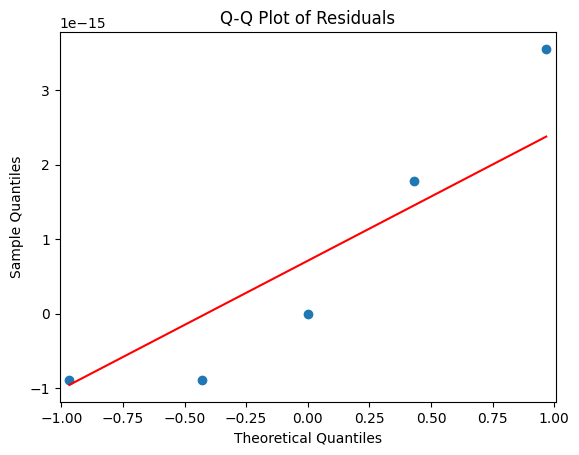

In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Пример данных
X1 = [1, 2, 3, 4, 5]
X2 = [2, 3, 5, 7, 11]
X3 = [5, 4, 3, 2, 1]
X4 = [1, 3, 2, 4, 5]
y = [2, 3, 5, 7, 11]

# Создаем DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'y': y})

# Определяем независимые и зависимые переменные
X = data[['X1', 'X2', 'X3', 'X4']]  # Независимые переменные
y = data['y']                        # Зависимая переменная

# Добавляем константу (свободный член)
X = sm.add_constant(X)

# Создаем модель множественной регрессии
model = sm.OLS(y, X).fit()

# Получаем результаты
print(model.summary())

# График Q-Q для проверки нормальности остатков
residuals = model.resid
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()
